# Distributional Q-learning on Atari Freeway
### Code for Chapter 7 of _Deep Reinforcement Learning in Action_ 
#### by Alex Zai and Brandon Brown
An implementation of "A Distributional Perspective on Reinforcement Learning" by Bellemare et al 2017

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from random import shuffle
import gym
from collections import deque
import skvideo.io
from skimage.transform import resize
from skimage import img_as_ubyte

In [2]:
workdir = "/Users/brandonbrown/Dropbox/DeepReinforcementLearning/media/Ch 7/"

Create the gym environment for Atari Freeway.
To simplify the algorithm and focus on the topics of interest, we use the ram version of Freeway rather than the raw pixels. In the ram version, the environment's states are 128-element vectors as opposed to RGB frames. This allows us to use a much simpler (i.e. non-convolutional, fewer layers) neural network so we can see the results of training faster.

In [101]:
env = gym.make('Freeway-ram-v0')
aspace = 3
env.env.get_action_meanings()

['NOOP', 'UP', 'DOWN']

In [3]:
def update_dist(r,support,probs,lim=(-10.,10.),gamma=0.8):
    """
    This function takes a discrete probability distribution over the range of rewards
    and updates the distribution based on a single new reward observation.
    `r` is a float indicating the observed reward
    `support`, is a vector of the distribution's support, e.g. uniformly spaced numbers from -10 to +10
    `probs`, is the vector of probabilities over `support`
    `lim`, tuple of floats, are the lower and upper limits of the support
    `gamma`, float, is the discount factor
    """
    nsup = probs.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    bj = np.round((r-vmin)/dz)
    bj = int(np.clip(bj,0,nsup-1))
    m = probs.clone()
    j = 1
    for i in range(bj,1,-1):
        m[i] += np.power(gamma,j) * m[i-1]
        j += 1
    j = 1
    for i in range(bj,nsup-1,1):
        m[i] += np.power(gamma,j) * m[i+1]
        j += 1
    m /= m.sum()
    return m

Let's see an example of how `update_dist` works. We first create a uniform discrete distribution over the support of evenly spaced numbers from -10 to 10.

<BarContainer object of 51 artists>

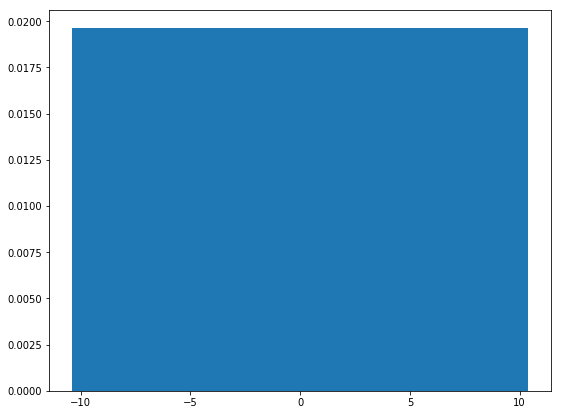

In [129]:
plt.figure(figsize=(9,7))
vmin,vmax=-10.,10.
nsup=51
support = np.linspace(vmin,vmax,nsup)
probs = np.ones(nsup)
probs /= probs.sum()
Z = torch.from_numpy(probs).float()
plt.bar(support,probs)
#plt.savefig(workdir + "uniform_dist.pdf")

Let's see how observing a single reward updates the distribution.

<BarContainer object of 51 artists>

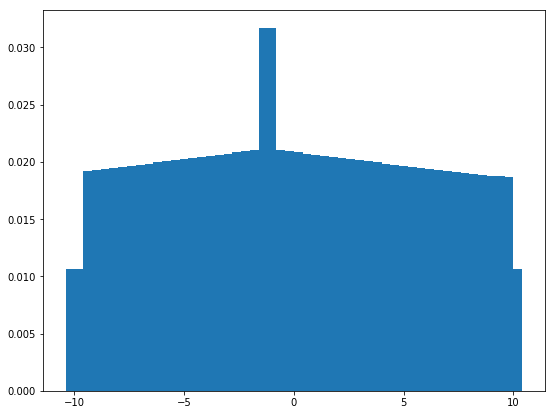

In [113]:
plt.figure(figsize=(9,7))
ob_reward = -1
Z = update_dist(ob_reward, torch.from_numpy(support).float(), Z, lim=(vmin,vmax), gamma=0.1)
plt.bar(support, Z)
#plt.savefig(workdir + "posterior_dist_1reward.pdf")

Now we simulate observing a sequence of rewards and see how it changes the distribution. You will see little peaks at the observed rewards but it is still fairly uniform. Try changing the `gamma` to see how this affects the distribution updating. A small `gamma` will result in small updates from prior to posterior distribution, whereas a `gamma` closer to `1` will result in large updates.

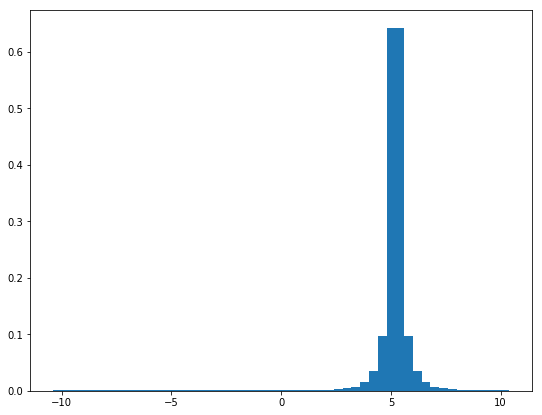

In [132]:
plt.figure(figsize=(9,7))
ob_rewards = [10,10,10,0,1,0,-10,-10,10,10]
for i in range(len(ob_rewards)):
    Z = update_dist(ob_rewards[i], torch.from_numpy(support).float(), Z, lim=(vmin,vmax), gamma=0.7)
plt.bar(support, Z)
#plt.savefig(workdir + "posterior_dist1_rseq.pdf")

In [104]:
support

array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
        -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
        -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
         0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
         4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
         8. ,   8.4,   8.8,   9.2,   9.6,  10. ])

In [4]:
def get_target_dist(dist_batch,action_batch,reward_batch,support,lim=(-10,10),gamma=0.8):
    """
    Given a mini-batch of Q-value distribution predictions,
    this function produces the target distribution used in the loss
    function to update the DQN
    
    `dist_batch`: Ax51xB where A is the action space size and B is batch size
    `action_batch`: dim=B vector of integers in {0,1,2} of actions
    `reward_batch`: dim=B vector of floats
    `lim`:2-tuple, indicates the lower and upper bound of the support
    `gamma`, float in [0,1], the discount factor
    """
    nsup = support.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    #
    target_dist_batch = dist_batch.clone()
    #
    for i in range(dist_batch.shape[0]): #loop through batch dimension
        dist_full = dist_batch[i]
        action = int(action_batch[i].item())
        dist = dist_full[action]
        r = reward_batch[i]
        if r != -1: #terminal state, target is degenerate distribuation at reward
            target_dist = torch.zeros(nsup)
            bj = np.round((r-vmin)/dz)
            bj = int(np.clip(bj,0,nsup-1))
            target_dist[bj] = 1.
        else:
            target_dist = update_dist(r,support,dist,lim=lim,gamma=gamma)
        target_dist_batch[i,action,:] = target_dist
        
    return target_dist_batch

In [5]:
def dist_dqn(x,theta,aspace=3):
    """
    3 layer neural network
    `x` is input vector of dim 128
    `theta` is a parameter vector that will be unpacked into 3 separate layer matrices
        layer1: L1 x X -> 100x128 x 128xB -> 100xB
        layer2: L2 x L1 -> 25x100 x 100xB -> 25xB
        layer3: L3 x L2 -> 3x25x51 x 25xB -> 3x51xB
        where `B` is the batch size dimension
        
    Returns a Batch Sizex A x 51 tensor where A is the action-space size
    """
    dim0 = 128
    dim1 = 100
    dim2 = 25
    dim3 = 51
    t1 = dim0*dim1
    t2 = dim2*dim1
    theta1 = theta[0:t1].reshape(dim0,dim1)
    theta2 = theta[t1:t1 + t2].reshape(dim1,dim2)
    #
    l1 = x @ theta1 #B x 128 x 128 x 100 = B x 100
    l1 = torch.selu(l1)
    l2 = l1 @ theta2 # B x 100 x 100 x 25 = B x 25
    l2 = torch.selu(l2)
    l3 = []
    for i in range(aspace):
        step = dim2*dim3
        theta5_dim = t1 + t2 + i * step
        theta5 = theta[theta5_dim:theta5_dim+step].reshape(dim2,dim3)
        l3_ = l2 @ theta5 #B x 25 x 25 x 51 = B x 51
        l3.append(l3_)
    l3 = torch.stack(l3,dim=1) # B x 3 x 51
    l3 = torch.nn.functional.softmax(l3,dim=2)
    return l3.squeeze()

In [110]:
def get_action(dist,support):
    """
    This function returns an integer action in [0,1,2]
    `dist` input is a Ax51xB discrete distribution over Q-values for each action
    where `A` is the action-space size, and `B` is the batch dimension.
    Get expectations w.r.t. to each action, take action w/ highest q-value
    
    Output:
    - `actions`: vector of integers in {0,1,2}, dimension dist.shape[0] (batch size)
    """
    actions = []
    for b in range(dist.shape[0]): #loop through batch dimension
        expectations = [support @ dist[b,a,:] for a in range(dist.shape[1])]
        action = int(np.argmax(expectations))
        actions.append(action)
    actions = torch.Tensor(actions).int()
    return actions

In [6]:
def lossfn(x,y):
    """
    Cross-Entropy Loss between prediction distribution `x` and target distribution `y`
    `x`: B x A x 51 tensor where `B` is batch dimension, `A` is action dimension
    `y` is B x A x 51 tensor
    
    Output
    - `loss`: Float
    """
    loss = torch.Tensor([0.])
    loss.requires_grad=True
    for i in range(x.shape[0]): #loop through batch dimension
        loss_ = -1 *  torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0)
        loss = loss + loss_
    return loss

def preproc_state(state):
    """
    Takes numpy array from env.reset or env.step
    and converts to PyTorch Tensor, adds batch dimension and normalizes
    
    Output:
    - `p_state`: PyTorch tensor of dimensions 1x128
    """
    p_state = torch.from_numpy(state).unsqueeze(dim=0).float()
    p_state = torch.nn.functional.normalize(p_state,dim=1)
    #
    return p_state

In [36]:
def get_dist_plot(env,dist,support,shape=(105,80,3)):
    """
    This function renders a side-by-side RGB image (returned as numpy array)
    of the current environment state (left) next to the current predicted probability distribution
    over rewards.
    
    `env` OpenAI Gym instantiated environment object
    `dist`: A x 51 tensor , where `A` is action space dimension
    `support` vector of supports
    `shape` (RGB: width,height,channels) desired output image size
    
    Output:
    - numpy array of RGB image (w,ht,ch)
    """
    cs = ['cyan','yellow','red','green','magenta']
    fig,ax=plt.subplots(1,1)
    fig.set_size_inches(5,5)
    for i in range(dist.shape[0]): #loop through actions
        _ = ax.bar(support.data.numpy(),dist[i,:].data.numpy(),\
                label='{}'.format(env.env.get_action_meanings()[i]),alpha=0.9,color=cs[i])
    ax.get_yaxis().set_visible(False)
    support_ = np.linspace(support.min(),support.max(),5)
    ax.set_xticks(support_)
    ax.set_xticklabels(support_)
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='x', colors='white')
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    fig.legend(loc='upper left',prop={'size': 20})
    plt.close(fig)
    width, height = fig.get_size_inches() * fig.get_dpi()
    width,height=int(width),int(height)
    fig.canvas.draw()
    image1 = np.fromstring(fig.canvas.tostring_rgb(), sep='', dtype='uint8').reshape(height,width,3)
    image2 = resize(image1,shape)
    image2 = img_as_ubyte(image2)
    state_render = img_as_ubyte(resize(env.render('rgb_array'),shape))
    image3 = np.hstack((state_render,image2))
    return image3

#### Testing with Random Distributions

To test the Dist-DQN and other functions, we train the dist-DQN to learn the reward distributions for 2 observed states (randomly created).

In [123]:
#Initialize DQN parameter vector
aspace = 3
tot_params = 128*100 + 25*100 + aspace*25*51
theta = torch.randn(tot_params)/10.
theta.requires_grad=True
theta_2 = theta.detach().clone() #initialize paramaters for target network
#
vmin,vmax= -10,10
gamma=0.9
lr = 0.00001
update_rate = 75
support = torch.linspace(-10,10,51)
state = torch.randn(2,128)/10.
action_batch = torch.Tensor([0,2])
reward_batch = torch.Tensor([0,10])
losses = []
pred_batch = dist_dqn(state,theta,aspace=aspace)
target_dist = get_target_dist(pred_batch2,action_batch,reward_batch, \
                                 support, lim=(vmin,vmax),gamma=gamma)

In [125]:
#training loop
for i in range(1000):
    reward_batch = torch.Tensor([0,8]) + torch.randn(2)/10.0 #add some random noise to rewards to make it harder
    pred_batch = dist_dqn(state,theta,aspace=aspace)
    pred_batch2 = dist_dqn(state,theta_2,aspace=aspace)
    target_dist = get_target_dist(pred_batch2,action_batch,reward_batch, \
                                 support, lim=(vmin,vmax),gamma=gamma)
    loss = lossfn(pred_batch,target_dist.detach())
    losses.append(loss.item())
    loss.backward()
    # Gradient Descent
    with torch.no_grad():
        theta -= lr * theta.grad
    theta.requires_grad = True
    
    if i % update_rate == 0: #sync target network parameters with main model parameters
        theta_2 = theta.detach().clone()

Let's see how well the last prediction matches the target distribution. If `gamma` is very low, they will match well even without training since the target distribution will only be a very slight update of the starting distribution. If `gamma` is high, it will take many iterations of training before they become well-matched.

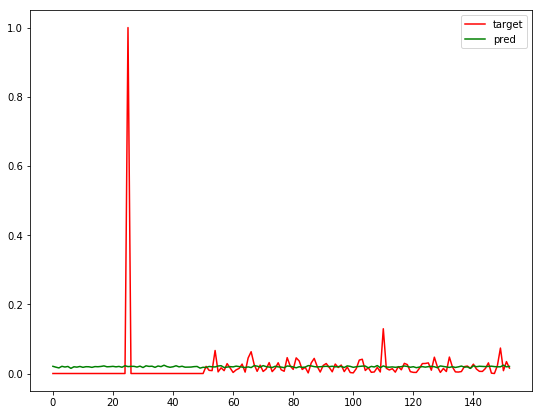

In [124]:
plt.figure(figsize=(9,7))
plt.plot((target_dist.flatten(start_dim=1)[0].data.numpy()),color='red',label='target')
plt.plot((pred_batch.flatten(start_dim=1)[0].data.numpy()),color='green',label='pred')
plt.legend()
#plt.savefig(workdir+"dqntest_comparison_untrained.png")

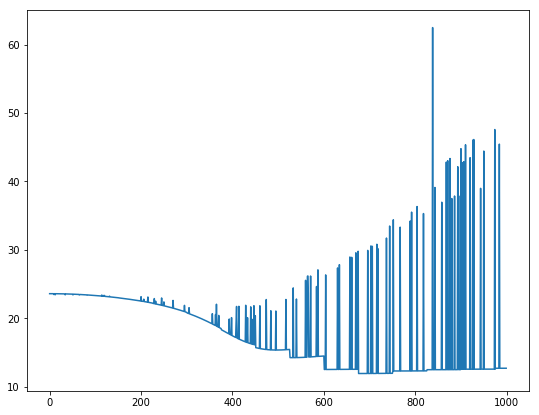

In [126]:
plt.figure(figsize=(9,7))
plt.plot(losses)
#plt.savefig(workdir+"dqntest_losses.png")

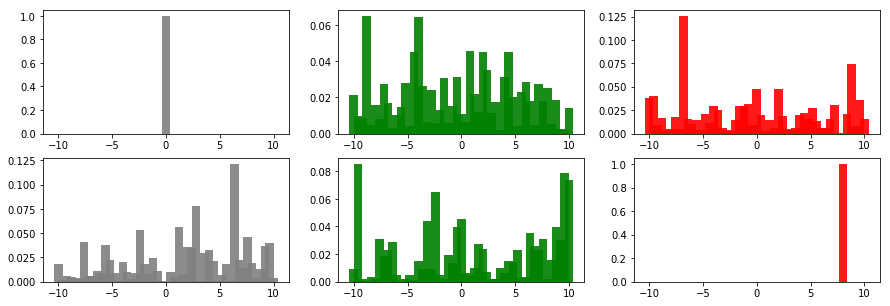

In [99]:
tpred = pred_batch
cs = ['gray','green','red']
num_batch = 2
labels = ['Action {}'.format(i,) for i in range(aspace)]
fig,ax = plt.subplots(nrows=num_batch,ncols=aspace)
fig.set_size_inches((15,5))

for j in range(num_batch): #loop through 5 first experiences in batch
    for i in range(tpred.shape[1]): #loop through actions
        ax[j,i].bar(support.data.numpy(),tpred[j,i,:].data.numpy(),\
                label='Action {}'.format(i),alpha=0.9,color=cs[i])

#fig.savefig(workdir+"distdqn_test_batch_dist_plot.pdf")

### Dist-DQN on Atari Freeway

In [111]:
vmin,vmax = -10,10
replay_size = 200
batch_size = 50
nsup = 51
dz = (vmax - vmin) / (nsup-1)
support = torch.linspace(vmin,vmax,nsup)

In [112]:
replay = deque(maxlen=replay_size) #experience replay buffer
lr = 0.0001 #learning rate
gamma = 0.1 #discount factor
epochs = 1300
eps = 0.20 #starting epsilon for epsilon-greedy policy
eps_min = 0.05 #ending epsilon
priority_level = 10 #prioritized-replay; duplicate high-value experiences in the replay
update_freq = 25 #update the target network every 100 steps

In [113]:
#Initialize DQN parameter vector
tot_params = 128*100 + 25*100 + aspace*25*51  #total number of parameters for dist-DQN
theta = torch.randn(tot_params)/10. #randomly initialize parameters for dist-DQN
theta.requires_grad=True
theta_2 = theta.detach().clone() #initialize paramaters for target network

In [114]:
%%time
#2min w/o frame rendering
#main training loop
losses = []
cum_rewards = [] #stores each win (successful freeway crossing)
renders = []
state = preproc_state(env.reset())

for i in range(epochs):
    #get Q-distribution, take action
    pred = dist_dqn(state,theta,aspace=aspace)
    if i < replay_size or np.random.rand(1) < eps:
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.unsqueeze(dim=0).detach(),support).item()
    state2, reward, done, info = env.step(action)
    state2 = preproc_state(state2)
    #
    if reward == 1: cum_rewards.append(1) 
    reward = 10 if reward == 1 else reward
    reward = -10 if done else reward
    reward = -1 if reward == 0 else reward
    #
    '''if i % 5 == 0:
        render_image = get_dist_plot(env,pred,support)
        renders.append(render_image)'''
    #
    #add experience to replay buffer
    exp = (state,action,reward,state2)
    replay.append(exp)
    
    if reward == 10: #prioritized replay
        print("Won at i={}".format(i,))
        for e in range(priority_level):
            replay.append(exp)
            
    shuffle(replay)
    # update state
    state = state2
    
    #Train with a mini-batch
    if i == replay_size+1:
        print("Training started")
    if len(replay) == replay_size:
        #collect mini-batch
        indx = np.random.randint(low=0,high=len(replay),size=batch_size)
        exps = [replay[j] for j in indx]
        state_batch = torch.stack([ex[0] for ex in exps],dim=1).squeeze()
        action_batch = torch.Tensor([ex[1] for ex in exps])
        reward_batch = torch.Tensor([ex[2] for ex in exps])
        state2_batch = torch.stack([ex[3] for ex in exps],dim=1).squeeze()
        #
        pred_batch = dist_dqn(state_batch.detach(),theta,aspace=aspace)
        pred2_batch = dist_dqn(state2_batch.detach(),theta_2,aspace=aspace)
        #
        target_dist = get_target_dist(pred2_batch,action_batch,reward_batch, \
                                     support, lim=(vmin,vmax),gamma=gamma)
        loss = lossfn(pred_batch,target_dist.detach())
        losses.append(loss.item())
        loss.backward()
        # Gradient Descent
        with torch.no_grad():
            theta -= lr * theta.grad
        theta.requires_grad = True
        
    if i % update_freq == 0: #sync target network parameters with main model parameters
        theta_2 = theta.detach().clone()
        
    #Decrement `eps`
    if i > 100 and eps > eps_min:
        dec = 1./np.log2(i)
        dec /= 1e3
        eps -= dec
    
    #Reset env if done
    if done:
        state = preproc_state(env.reset())
        done = False
        print("End of game.")

#Stack generated frames into a movie
if len(renders) > 1:
    renders = np.stack(renders,axis=0)

Training started
Won at i=693
Won at i=824
Won at i=1048
Won at i=1200
Won at i=1299
CPU times: user 1min 44s, sys: 1 s, total: 1min 45s
Wall time: 1min 51s


In [67]:
#renders = np.stack(renders,axis=0)

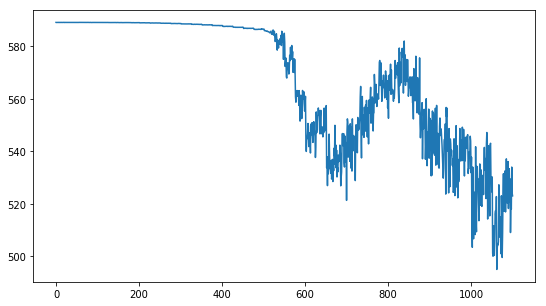

In [115]:
plt.figure(figsize=(9,5))
plt.plot(losses)
#plt.savefig("/Users/brandonbrown/Dropbox/DeepReinforcementLearning/media/Ch 7/lossplot.png")

In [116]:
cum_rewards

[1, 1, 1, 1, 1]

In [338]:
#Create mp4 video from rendered numpy frames
skvideo.io.vwrite("freeway_g0p2_5000f.mp4", renders)
print("Done.")

Done.


Display the reward distributions for each action for a random sample of 5 experiences in the replay buffer:

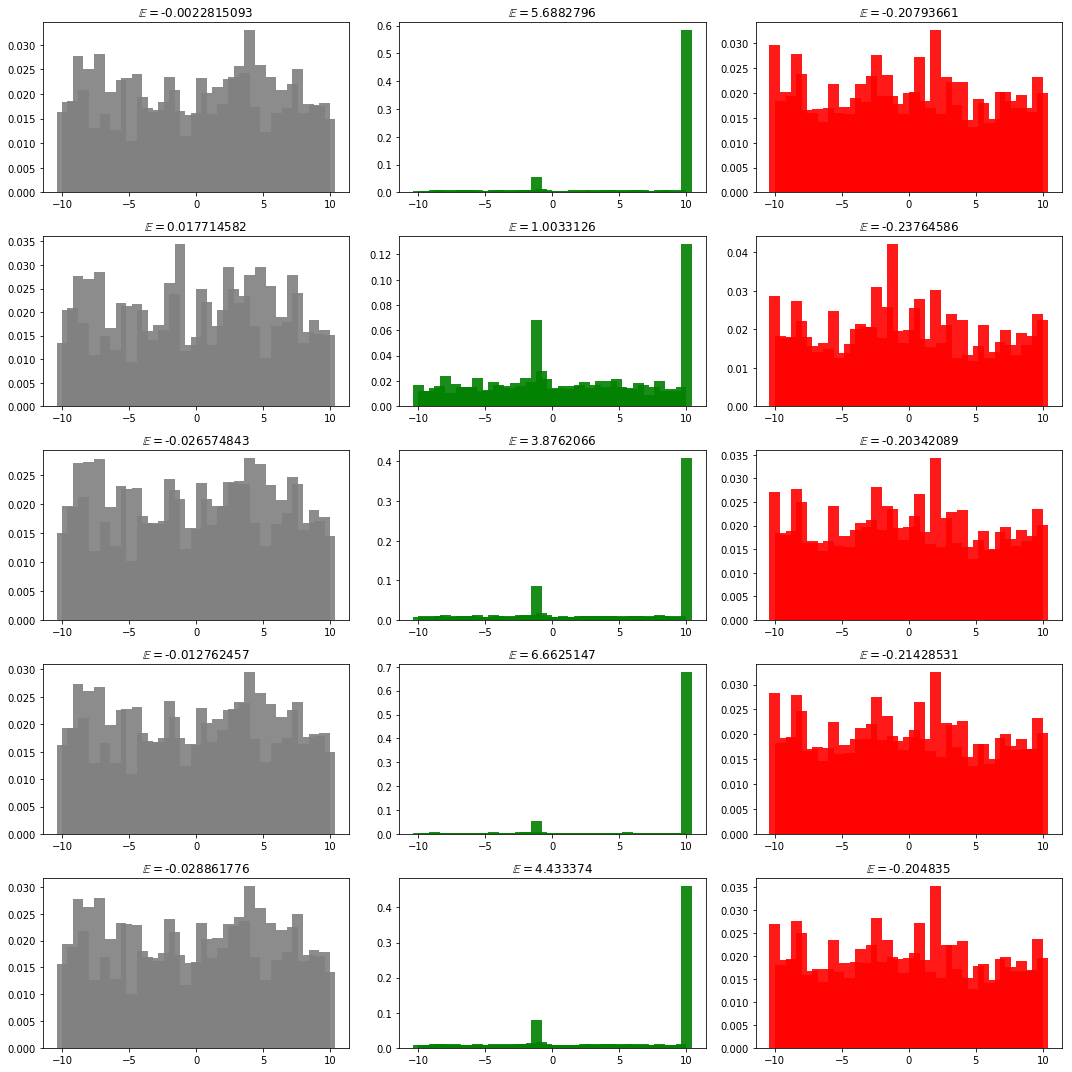

In [117]:
tpred = pred_batch
#tpred = target_dist
cs = ['gray','green','red']
num_batch = 5
batch_ind = np.random.randint(0,tpred.shape[0],num_batch)
labels = ['Action {}'.format(i,) for i in range(aspace)]
fig,ax = plt.subplots(nrows=num_batch,ncols=aspace)
fig.set_size_inches((15,15))
for j_ in range(num_batch): #loop through 5 first experiences in batch
    j = batch_ind[j_]
    for i in range(tpred.shape[1]): #loop through actions
        ax[j_,i].bar(support.data.numpy(),tpred[j,i,:].data.numpy(),\
                label='Action {}'.format(i),alpha=0.9,color=cs[i])
        ev = support.data.numpy() @ tpred[j,i,:].data.numpy()
        ax[j_,i].set_title("$\mathbb{E} = $" + str(ev))
fig.tight_layout()
#fig.savefig("/Users/brandonbrown/Dropbox/DeepReinforcementLearning/media/Ch 7/act_dist_examples.pdf")

In [348]:
#[r for (s,a,r,s) in replay]

In [84]:
"""
See what actions the Dist-DQN produces after training. It should be predicting action UP (1) most often.
"""
state = preproc_state(env.reset())
for i in range(20):
    pred = dist_dqn(state,theta_2,3)
    image = get_dist_plot(env,pred,support,shape=(210,160,3))
    action = get_action(pred.unsqueeze(dim=0).detach(),support).item()
    print(action,end=", ")
    s,r,d,i = env.step(action)
    state = preproc_state(s)

/Users/brandonbrown/anaconda3/envs/deeprl/lib/python3.6/site-packages/ipykernel/__main__.py:37: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/Users/brandonbrown/anaconda3/envs/deeprl/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

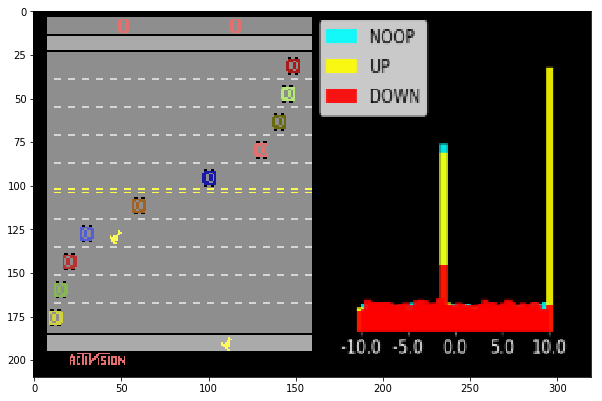

In [62]:
plt.figure(figsize=(10,9))
plt.imshow(image)
#kplt.savefig("/Users/brandonbrown/Dropbox/DeepReinforcementLearning/media/Ch 7/sidebysidevideoframe.png")